In [1]:
import torch
from torch.nn import CrossEntropyLoss
import models.networks as networks
from torch.optim import Adam, SGD
import glob
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from pytorch_wavelets import DWTForward, DWTInverse
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline


In [2]:
class ds(Dataset):
    def __init__(self, main_dir, device, transform = [transforms.Resize((768,1024), interpolation = 4), transforms.ToTensor()], levels = 2):
        self.main_dir = main_dir
        self.transforms = transforms.Compose(transform)
        self.image_list = glob.glob(main_dir+"/*/*.png")
        self.levels = levels
        self.names = [os.path.basename(x) for x in self.image_list]
        self.xfm = DWTForward(J=self.levels, mode='periodization', wave='bior3.3').to(device)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img = Image.open(self.image_list[idx])
        # img = img.resize((768, 1024),3)
        img = self.transforms(img).unsqueeze(0).to(device)
        Yl, Yh = self.xfm(img)
        x = []
        y = 0
        for i in Yh:
            x.append(torch.reshape(i, (i.shape[0]*i.shape[1]*i.shape[2], i.shape[3], i.shape[4])))
        if len(self.names[idx])==7 :
            y = 5
        else:
            y = 5 - int(self.names[idx][-6:-4]) 
        return x,y

In [3]:
def QA_loss(op,target):
    loss = torch.sum(torch.abs(target - op))
    return loss

losses = []
test_losses = []

def train(model, device, train_loader,test_loader,  optimizer, epochs):
    # torch.cuda.empty_cache()
    prev_loss = 0
    counter = 0
    for j in range(epochs):
        if counter == 3:
            print("Early Stopping")
            break

        model.train()

        for k,i in enumerate(train_loader):
            #LOADING THE DATA IN A BATCH
            data, target = i
    
            #MOVING THE TENSORS TO THE CONFIGURED DEVICE
            data1 = data[0].to(device)
            data2 = data[1].to(device)
            target = target.to(device)
            #FORWARD PASS
            output = model(x = data1.float(), x1 = data2.float())
            loss = QA_loss(output, target) 
            
            #BACKWARD AND OPTIMIZE
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # PREDICTIONS
            loss_p = loss.item() 
            if k%8 == 0:
                print("Loss on training set is" ,         
                loss_p)

        test_loss = test(model, device, test_loader)
        test_losses.append(test_loss)
        losses.append(loss_p)

        plt.figure()
        plt.plot(losses, 'b')
        plt.plot(test_losses, 'r')
        plt.show(block = False)
        if(test_loss>prev_loss):
            counter+=1
        else:
            counter = 0
        prev_loss = test_loss


def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    
    # set the requires_grad flag to false as we are in the test model
    with torch.no_grad():
        for i in test_loader:
            
            #LOAD THE DATA IN A BATCH
            data,target = i
            
            # moving the tensors to the configured device
            data1 = data[0].to(device)
            data2 = data[1].to(device)
            target = target.to(device)
        
            # the model on the data
            output = model(data1.float(), data2.float())
                       
            #PREDICTIONS
            loss = QA_loss(output, target)
            loss_p = (loss.item())

            
    print("Loss on test set is" ,loss_p)
    print("***********************************************************")
    return loss_p


In [9]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
load = True
if load:
    netQ = torch.load("D:\\upla_sir_stuff\\superres\\experiments\\qadwt2.pt")
else:
    netQ = networks.define_Q2().to(device)
optimizer = Adam(netQ.parameters(), lr=0.007)

In [5]:
data = ds("D:\\upla_sir_stuff\\kadid10k\\images", device)
train_data, test_data = random_split(data, [int(len(data)*0.7),len(data)-int(len(data)*0.7)])
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, shuffle=True)
print(len(train_data), len(test_data))

NameError: name 'device' is not defined

In [6]:
train(netQ, device, train_loader, test_loader, optimizer, 50)


NameError: name 'netQ' is not defined

In [7]:
torch.save(netQ, "D:\\upla_sir_stuff\\superres\\experiments\\qadwt2.pt")

NameError: name 'netQ' is not defined

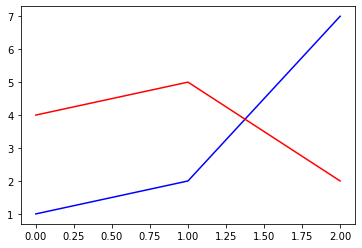

In [8]:
for i in range(5):
    clear_output()
    losses = [1,2,3+i]
    test_losses = [4,5,6-i]
    plt.figure("asd")
    plt.plot(losses, 'b')
    plt.plot(test_losses, 'r')
    plt.show(block = False)
    plt.pause(0.5)